# Logistic Regression with scikit-learn

## Dataset

The dataset is the [affairs dataset](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html) that comes with [Statsmodels](http://statsmodels.sourceforge.net/). It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a [1978 paper](http://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf) from the Journal of Political Economy.

## Description of Variables

The dataset contains 6366 observations of 9 variables:

* `rate_marriage`: woman's rating of her marriage (1 = very poor, 5 = very good)
* `age`: woman's age
* `yrs_married`: number of years married
* `children`: number of children
* `religious`: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
* `educ`: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
* `occupation`: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
* `occupation_husb`: husband's occupation (same coding as above)
* `affairs`: time spent in extra-marital affairs

## Problem Statement

Decided to treat this as a classification problem by creating a new binary variable `affair` (did the woman have at least one affair?) and trying to predict the classification for each woman.

## Import modules

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Pre-Processing

First, let's load the dataset and add a binary `affair` column.

In [3]:
# load dataset
dta = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

## Data Exploration

In [4]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


We can see that on average, women who have affairs rate their marriages lower, which is to be expected. Let's take another look at the `rate_marriage` variable.

In [5]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


An increase in `age`, `yrs_married`, and `children` appears to correlate with a declining marriage rating.

## Data Visualization

In [6]:
# show plots in the notebook
%matplotlib inline

Let's start with histograms of education and marriage rating.

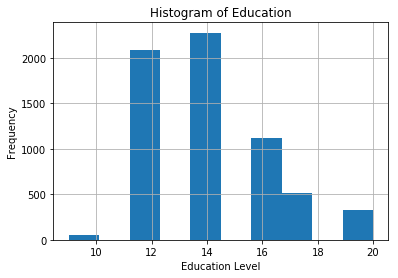

In [7]:
# histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

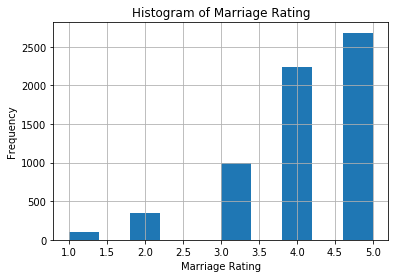

In [8]:
# histogram of marriage rating
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.

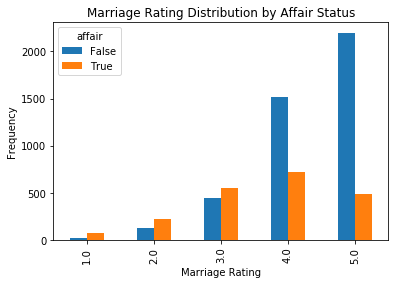

In [9]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

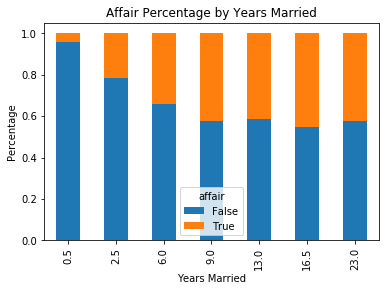

In [10]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

## Prepare Data for Logistic Regression

To prepare the data, I want to add an intercept column as well as dummy variables for `occupation` and `occupation_husb`, since I'm treating them as categorial variables.

In [11]:
features = ['rate_marriage', 'age', 'yrs_married', 'children', 'religious', 'educ',
            'occupation', 'occupation_husb']

xData = dta[features]

In [12]:
xData = pd.get_dummies(xData, columns=['occupation', 'occupation_husb'])
xData.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation_1.0,occupation_2.0,occupation_3.0,occupation_4.0,occupation_5.0,occupation_6.0,occupation_husb_1.0,occupation_husb_2.0,occupation_husb_3.0,occupation_husb_4.0,occupation_husb_5.0,occupation_husb_6.0
0,3.0,32.0,9.0,3.0,3.0,17.0,0,1,0,0,0,0,0,0,0,0,1,0
1,3.0,27.0,13.0,3.0,1.0,14.0,0,0,1,0,0,0,0,0,0,1,0,0
2,4.0,22.0,2.5,0.0,1.0,16.0,0,0,1,0,0,0,0,0,0,0,1,0
3,4.0,37.0,16.5,4.0,3.0,16.0,0,0,0,0,1,0,0,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,14.0,0,0,1,0,0,0,0,0,0,1,0,0


In [13]:
yData = dta['affair']
yData.head()

0    1
1    1
2    1
3    1
4    1
Name: affair, dtype: int64

## Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [14]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(xData, yData)

# check the accuracy on the training set
model.score(xData, yData)

0.7260446120012567

73% accuracy seems good, but what's the null error rate?

In [15]:
# what percentage had affairs?
yData.mean()

0.32249450204209867

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.

Let's examine the coefficients to see what we learn.

In [16]:
# examine the coefficients
pd.DataFrame(list(zip(xData.columns, np.transpose(model.coef_))))

,0,1
0,rate_marriage,[-0.698726944116]
1,age,[-0.0565932971926]
2,yrs_married,[0.104153574253]
3,children,[0.0182822315986]
4,religious,[-0.368961477709]
5,educ,[0.008057569318]
6,occupation_1.0,[-0.16262316671]
7,occupation_2.0,[0.222201225567]
8,occupation_3.0,[0.531042929304]
9,occupation_4.0,[0.270571351303]


Increases in marriage rating and religiousness correspond to a decrease in the likelihood of having an affair. For both the wife's occupation and the husband's occupation, the lowest likelihood of having an affair corresponds to the baseline occupation (student), since all of the dummy coefficients are positive.

## Model Evaluation Using a Validation Set

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [17]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [18]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print(predicted)

[1 0 0 ..., 0 0 0]


In [19]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print(probs)

[[ 0.35398125  0.64601875]
 [ 0.908242    0.091758  ]
 [ 0.72492823  0.27507177]
 ..., 
 [ 0.55404183  0.44595817]
 [ 0.81295703  0.18704297]
 [ 0.74573372  0.25426628]]


As you can see, the classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than 0.5.

Now let's generate some evaluation metrics.

In [19]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.729319371728
0.745170503754


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

We can also see the confusion matrix and a classification report with other metrics.

In [20]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1172  131]
 [ 386  221]]
             precision    recall  f1-score   support

          0       0.75      0.90      0.82      1303
          1       0.63      0.36      0.46       607

avg / total       0.71      0.73      0.71      1910



## Predicting the Probability of an Affair

Just for fun, let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.

In [21]:
model.predict_proba(np.array([[3, 25, 3, 1, 4, 16, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]))

array([[ 0.77433686,  0.22566314]])

The predicted probability of an affair is 23%.